This model has potential of predicting how long an accident will block the road. Knowing this early helps emergency teams respond faster, reroute traffic, etc. It gives operations a heads-up on situations that will take hours, so they can act before delays pile up.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv("../data/processed/accidents.csv")

In [3]:

df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
df["end_time"]   = pd.to_datetime(df["end_time"], errors="coerce")

df["duration_min"] = (
    df["end_time"] - df["start_time"]
).dt.total_seconds() / 60

df["duration_min"] = df["duration_min"].clip(lower=0, upper=360)

df = df[df["duration_min"].notna()].copy()


## Feature Engineering

In [4]:
df["hour"] = df["start_time"].dt.hour
df["dayofweek"] = df["start_time"].dt.dayofweek
df["month"] = df["start_time"].dt.month

df["is_severe"] = (df["severity"] == 4).astype(int)
df["has_precip"] = (df["precipitationin"] > 0).astype(int)
df["low_visibility"] = (df["visibilitymi"] < 3).astype(int)

numeric_features = [
    "distancemi",
    "min_temperature_f",
    "humidity",
    "pressurein",
    "visibilitymi",
    "wind_speedmph",
    "precipitationin",
    "hour",
    "dayofweek",
    "month",
    "is_severe"
]
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = [
    "state",
    "city",
    "weather_condition"
]
categorical_features = [c for c in categorical_features if c in df.columns]

X = df[numeric_features + categorical_features]

y = df["duration_min"]


## Train/Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Transformers

In [6]:

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Modeling

In [7]:
reg = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        n_jobs=-1,
        random_state=42
    ))
])

reg.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluation

In [9]:
pred = reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("R^2:", r2_score(y_test, pred))


MAE: 37.894609834030256
R^2: 0.31887499320436097


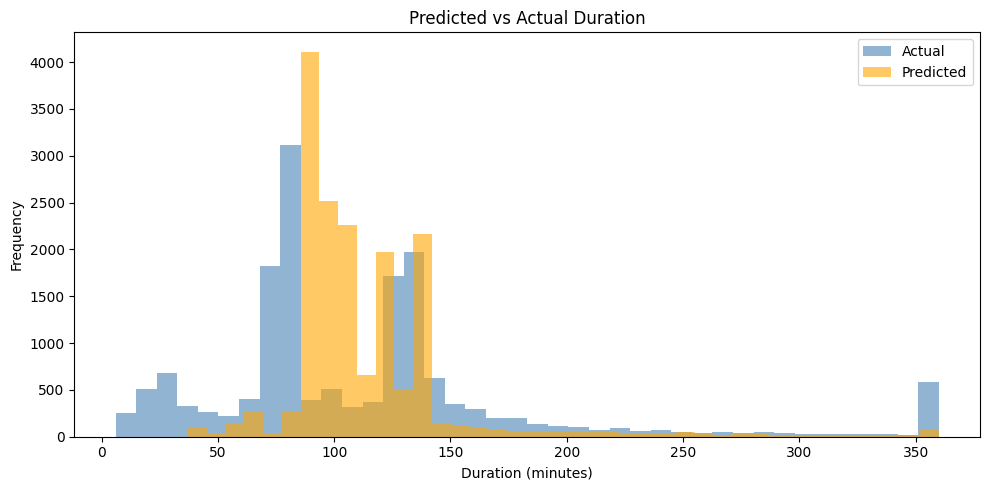

In [12]:
plt.figure(figsize=(10,5))

plt.hist(y_test, bins=40, alpha=0.6, label="Actual", color="steelblue")
plt.hist(pred, bins=40, alpha=0.6, label="Predicted", color="orange")

plt.title("Predicted vs Actual Duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


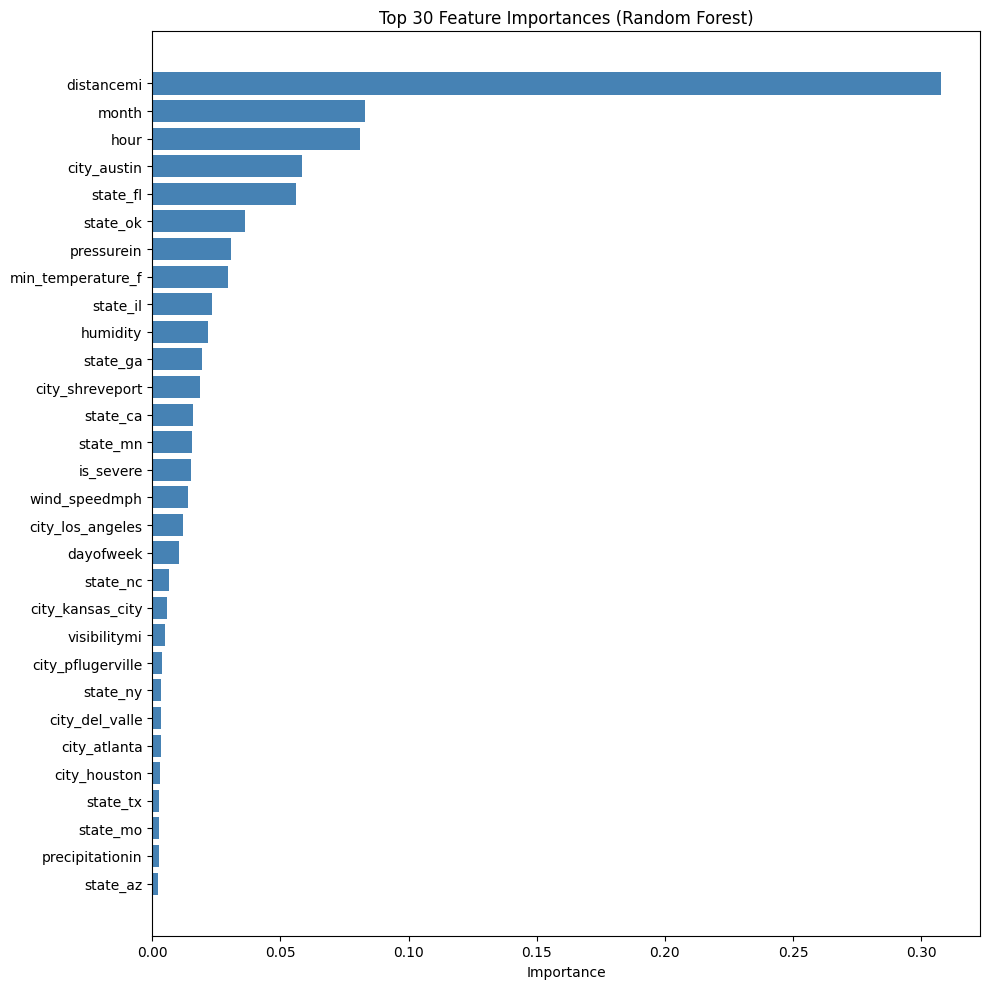

In [11]:
rf = reg.named_steps["model"]

num_features_out = numeric_features

cat_encoder = reg.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_features_out = list(cat_encoder.get_feature_names_out(categorical_features))

all_features = num_features_out + cat_features_out

importances = rf.feature_importances_

idx = np.argsort(importances)[::-1]
top_n = 30 

plt.figure(figsize=(10,10))
plt.barh(
    np.array(all_features)[idx][:top_n][::-1],
    importances[idx][:top_n][::-1],
    color="steelblue"
)

plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
